In [6]:
import os
import sysconfig
import tempfile
import requests

from pyspark.sql import functions
from pyspark.sql import SparkSession

%matplotlib inline
import matplotlib.pyplot as plt

Create a Spark Connect session to our cluster

In [9]:
spark = (
    SparkSession
        .builder
        .remote("sc://localhost:15002")
        .appName("example")
        .config("hive.metastore.uris", "thrift://localhost:9083")
        .enableHiveSupport()
        .getOrCreate()
)

# Load the Spark Connect jar
spark_connect_jar = f"{sysconfig.get_paths()['purelib']}/pyspark/jars/spark-connect_2.13-4.0.1.jar"
spark.addArtifacts(spark_connect_jar)


Ensure the data is loaded

In [10]:
url = "https://repo.stackable.tech/repository/misc/ny-taxi-data/yellow_tripdata_2020-12.parquet"
hdfs_path = "/taxi-data/raw/yellow_tripdata_2020-12.parquet"

# File download to HDFS
temp_path = None
try:
    # Check if file exists
    existing_df = spark.read.parquet(hdfs_path)
    existing_df.count()  # Force evaluation
    print(f"File already exists in HDFS: {hdfs_path}, with {existing_df.count()} rows")
    df = existing_df
except:
    print(f"File does not exist in HDFS, downloading from: {url}")
    temp_path = tempfile.mktemp(suffix='.parquet')
    
    # Download file
    response = requests.get(url)
    response.raise_for_status()
    
    # Save to temp file and upload to HDFS
    with open(temp_path, 'wb') as f:
        f.write(response.content)
    
    print(f"Downloaded and uploaded to: {hdfs_path}")
    spark.copyFromLocalToFs(temp_path, hdfs_path)
    
    # Read from HDFS
    df = spark.read.parquet(hdfs_path)
    print(f"Loaded {df.count()} rows from HDFS")

finally:
    if temp_path and os.path.exists(temp_path):
        os.remove(temp_path)
        print(f"Cleaned up temporary file")

File already exists in HDFS: /taxi-data/raw/yellow_tripdata_2020-12.parquet, with 1461898 rows


In [11]:
df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2020-12-01 00:07:13|  2020-12-01 00:18:12|            1.0|          7.6|       1.0|                 N|         138|         263|           1|       21.5|  3.0|    0.5|       2.

In [12]:
import pandas as pd
import numpy as np


# Use Spark for basic aggregations
basic_stats = df.agg(
    functions.count("*").alias("total_trips"),
    functions.avg("trip_distance").alias("avg_distance"),
    functions.avg("fare_amount").alias("avg_fare"),
    functions.avg("tip_amount").alias("avg_tip"),
    functions.sum("total_amount").alias("total_revenue")
).collect()[0]

print("Basic Statistics (from Spark):")
print(f"Total trips in sample: {basic_stats['total_trips']}")
print(f"Average trip distance: {basic_stats['avg_distance']:.2f} miles")
print(f"Average fare amount: ${basic_stats['avg_fare']:.2f}")
print(f"Average tip amount: ${basic_stats['avg_tip']:.2f}")
print(f"Total revenue: ${basic_stats['total_revenue']:.2f}")

# Convert to pandas only for matplotlib plotting
pdf = df.limit(10000).toPandas()
pdf['pickup_datetime'] = pd.to_datetime(pdf['tpep_pickup_datetime'])
pdf['hour'] = pdf['pickup_datetime'].dt.hour
pdf['day_of_week'] = pdf['pickup_datetime'].dt.day_name()
pdf['day_of_month'] = pdf['pickup_datetime'].dt.day

pdf.head()

Basic Statistics (from Spark):
Total trips in sample: 1461898
Average trip distance: 6.07 miles
Average fare amount: $12.21
Average tip amount: $1.96
Total revenue: $25726649.26


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_datetime,hour,day_of_week,day_of_month
0,1,2020-12-01 00:07:13,2020-12-01 00:18:12,1.0,7.60,1.0,N,138,263,1,...,2.50,6.12,0.3,33.92,2.5,NaN,2020-12-01 00:07:13,0,Tuesday,1
1,1,2020-12-01 00:41:19,2020-12-01 00:49:45,1.0,1.60,1.0,N,140,263,1,...,2.95,0.00,0.3,14.75,2.5,NaN,2020-12-01 00:41:19,0,Tuesday,1
2,2,2020-12-01 00:33:40,2020-12-01 01:00:35,1.0,16.74,2.0,N,132,164,1,...,2.50,6.12,0.3,63.92,2.5,NaN,2020-12-01 00:33:40,0,Tuesday,1
3,2,2020-12-01 00:02:15,2020-12-01 00:13:09,1.0,4.16,1.0,N,238,48,1,...,1.00,0.00,0.3,18.80,2.5,NaN,2020-12-01 00:02:15,0,Tuesday,1
4,2,2020-12-01 00:37:42,2020-12-01 00:45:11,1.0,2.22,1.0,N,238,41,2,...,0.00,0.00,0.3,9.80,0.0,NaN,2020-12-01 00:37:42,0,Tuesday,1


In [21]:
# Use Spark for aggregations needed for plotting
from pyspark.sql.functions import hour, dayofmonth

# Add time columns using Spark SQL functions
spark_df_with_time = df.withColumn("pickup_hour", hour("tpep_pickup_datetime")) \
                              .withColumn("pickup_day", dayofmonth("tpep_pickup_datetime"))

# Get hourly trip counts using Spark
hourly_trips_spark = spark_df_with_time.groupBy("pickup_hour").count().orderBy("pickup_hour").collect()
hourly_trips = {row['pickup_hour']: row['count'] for row in hourly_trips_spark}

# Get daily trip counts using Spark
daily_trips_spark = spark_df_with_time.groupBy("pickup_day").count().orderBy("pickup_day").collect()
daily_trips = {row['pickup_day']: row['count'] for row in daily_trips_spark}

# Get passenger count distribution using Spark
passenger_dist_spark = df.groupBy("passenger_count").count().orderBy("passenger_count").collect()
passenger_counts = {row['passenger_count']: row['count'] for row in passenger_dist_spark}

# Get payment type distribution using Spark
payment_dist_spark = df.groupBy("payment_type").count().orderBy("payment_type").collect()
payment_types = {row['payment_type']: row['count'] for row in payment_dist_spark}

# Get correlation using Spark
correlation_df = df.select("trip_distance", "fare_amount").toPandas()
correlation = correlation_df.corr().iloc[0,1]

# Get average fare by hour using Spark
avg_fare_hourly_spark = spark_df_with_time.groupBy("pickup_hour").avg("fare_amount").orderBy("pickup_hour").collect()
avg_fare_by_hour = {row['pickup_hour']: row['avg(fare_amount)'] for row in avg_fare_hourly_spark}

print(f"Spark-computed correlation between distance and fare: {correlation:.3f}")

Spark-computed correlation between distance and fare: 0.000


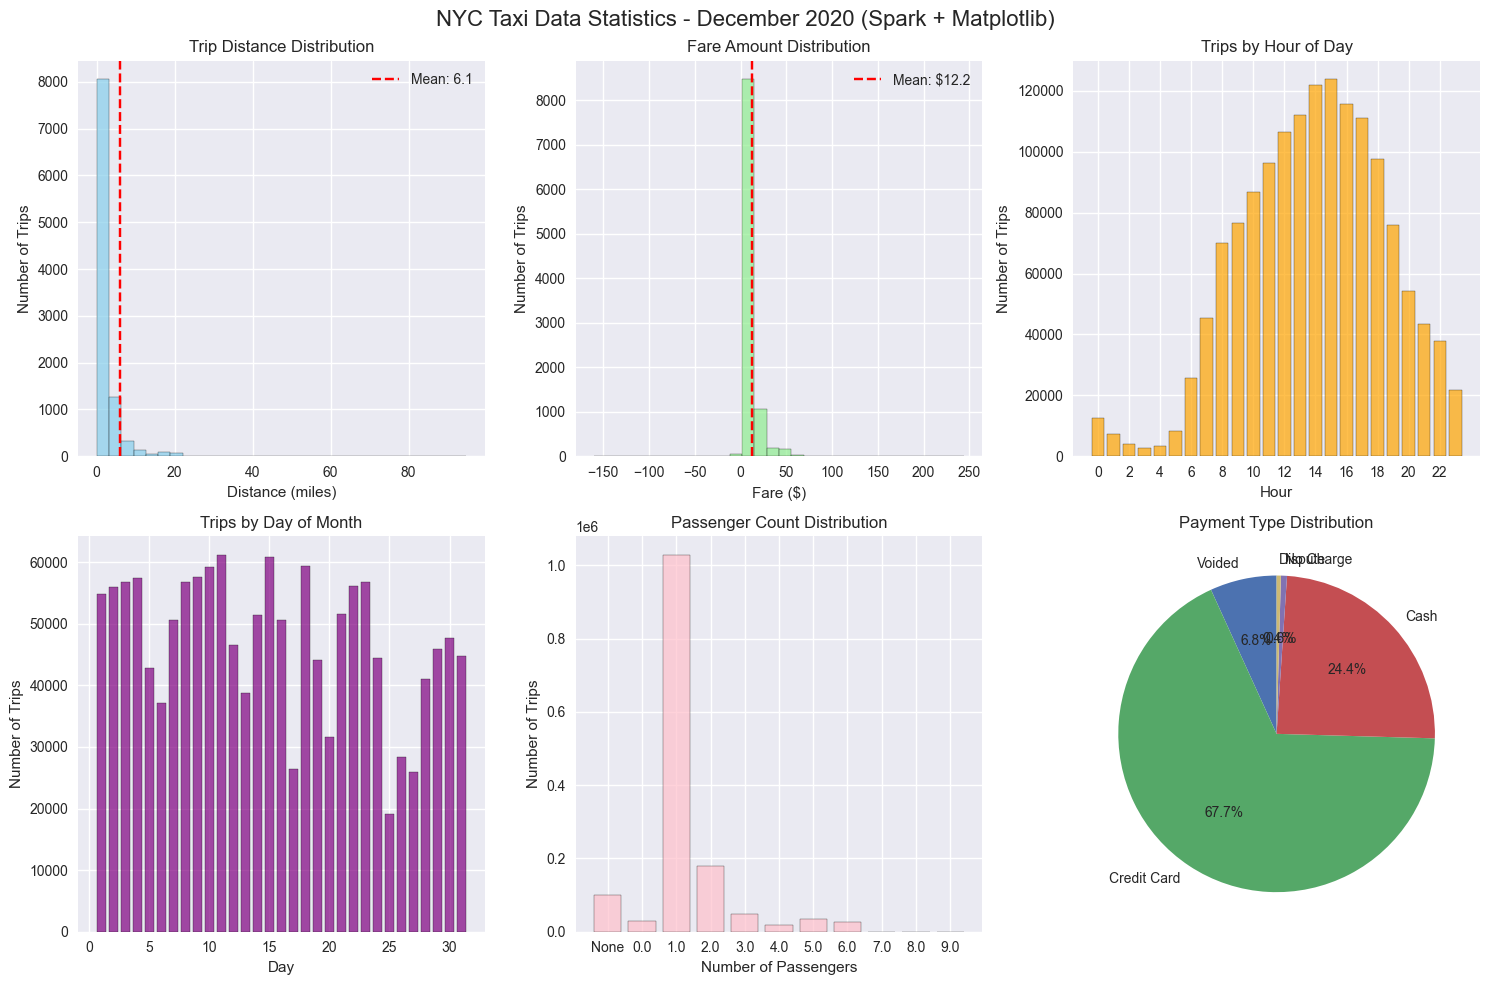

In [23]:
# Set up the plotting style
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('NYC Taxi Data Statistics - December 2020 (Spark + Matplotlib)', fontsize=16)

# 1. Trip Distance Distribution
axes[0,0].hist(pdf['trip_distance'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Trip Distance Distribution')
axes[0,0].set_xlabel('Distance (miles)')
axes[0,0].set_ylabel('Number of Trips')
axes[0,0].axvline(basic_stats['avg_distance'], color='red', linestyle='--', label=f'Mean: {basic_stats["avg_distance"]:.1f}')
axes[0,0].legend()

# 2. Fare Amount Distribution
axes[0,1].hist(pdf['fare_amount'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_title('Fare Amount Distribution')
axes[0,1].set_xlabel('Fare ($)')
axes[0,1].set_ylabel('Number of Trips')
axes[0,1].axvline(basic_stats['avg_fare'], color='red', linestyle='--', label=f'Mean: ${basic_stats["avg_fare"]:.1f}')
axes[0,1].legend()

# 3. Hourly Trip Pattern (using Spark results)
hours = list(hourly_trips.keys())
counts = list(hourly_trips.values())
axes[0,2].bar(hours, counts, alpha=0.7, color='orange', edgecolor='black')
axes[0,2].set_title('Trips by Hour of Day')
axes[0,2].set_xlabel('Hour')
axes[0,2].set_ylabel('Number of Trips')
axes[0,2].set_xticks(range(0, 24, 2))

# 4. Daily Trip Pattern (using Spark results)
days = list(daily_trips.keys())
day_counts = list(daily_trips.values())
axes[1,0].bar(days, day_counts, alpha=0.7, color='purple', edgecolor='black')
axes[1,0].set_title('Trips by Day of Month')
axes[1,0].set_xlabel('Day')
axes[1,0].set_ylabel('Number of Trips')

# 5. Passenger Count Distribution (using Spark results)
pass_counts = list(passenger_counts.keys())
pass_values = list(passenger_counts.values())
axes[1,1].bar([str(x) for x in pass_counts], pass_values, alpha=0.7, color='pink', edgecolor='black')
axes[1,1].set_title('Passenger Count Distribution')
axes[1,1].set_xlabel('Number of Passengers')
axes[1,1].set_ylabel('Number of Trips')

# 6. Payment Type Distribution (using Spark results)
pay_types = list(payment_types.keys())
pay_values = list(payment_types.values())
payment_labels = ['Credit Card', 'Cash', 'No Charge', 'Dispute', 'Unknown', 'Voided']
axes[1,2].pie(pay_values, labels=[payment_labels[int(i)-1] if int(i) <= len(payment_labels) else f'Type {int(i)}' for i in pay_types], 
              autopct='%1.1f%%', startangle=90)
axes[1,2].set_title('Payment Type Distribution')

plt.tight_layout()
plt.show()

In [24]:
# Additional insights using Spark-computed data
print("\nAdditional Insights (Spark-computed):")
max_hour = max(hourly_trips, key=hourly_trips.get)
print(f"Most common pickup hour: {max_hour}:00 ({hourly_trips[max_hour]} trips)")

max_day = max(daily_trips, key=daily_trips.get)
print(f"Busiest day: December {max_day} ({daily_trips[max_day]} trips)")

max_passengers = max(passenger_counts, key=passenger_counts.get)
print(f"Most common passenger count: {max_passengers} passenger(s)")

print(f"\nCorrelation between distance and fare: {correlation:.3f}")

# Average fare by hour (using Spark results)
print(f"\nAverage fare by hour of day (Spark-computed):")
for hour in range(0, 24, 4):
    fares_in_range = [avg_fare_by_hour[h] for h in range(hour, min(hour+4, 24)) if h in avg_fare_by_hour]
    if fares_in_range:
        avg_fare = sum(fares_in_range) / len(fares_in_range)
        print(f"  {hour:2d}:00 - {min(hour+3, 23):2d}:00: ${avg_fare:.2f}")


Additional Insights (Spark-computed):
Most common pickup hour: 15:00 (123786 trips)
Busiest day: December 11 (61194 trips)
Most common passenger count: 1.0 passenger(s)

Correlation between distance and fare: 0.000

Average fare by hour of day (Spark-computed):
   0:00 -  3:00: $15.10
   4:00 -  7:00: $15.16
   8:00 - 11:00: $11.30
  12:00 - 15:00: $12.55
  16:00 - 19:00: $11.95
  20:00 - 23:00: $13.12
